# Report Analisi Preliminare: Forces.csv

### 1. Panoramica del Dataset
* **Nome File:** forces.csv
* **Contenuto:** Matrice delle forze agenti su ciascun atomo ad ogni istante temporale.
* **Dimensione (Shape):** (50001, 415)
* **Separatore:** Tabulazione (\t) o misto. È stato necessario un parsing specifico con engine python.

### 2. Struttura delle Variabili
* **Colonna 0:** Timestamp (da rimuovere).
* **Colonne 1-414:** Componenti vettoriali della forza (Fx, Fy, Fz).
    * Le forze rappresentano la derivata dell'energia potenziale rispetto alla posizione.
    * Valori positivi e negativi indicano direzioni opposte di spinta/trazione.

### 3. Analisi dei Valori (Range Dinamico)
A differenza delle coordinate (che variano lentamente), le forze presentano:
* **Alta Variabilità:** I valori oscillano rapidamente tra numeri positivi e negativi anche molto grandi (es. -1000 a +1000).
* **Media vicino allo zero:** Per un sistema in equilibrio, le forze tendono a fluttuare attorno allo zero.
* **Scale diverse:** L'ordine di grandezza numerico è molto diverso rispetto alle coordinate. Questo rende obbligatoria la normalizzazione (Scaling) nello step successivo.

### 4. Ispezione Visiva (Grafico)
Il grafico delle forze mostra un andamento ad "alta frequenza" (simile a rumore o vibrazione rapida).
* **Interpretazione:** Questo è il comportamento corretto. Gli atomi vibrano freneticamente a causa delle interazioni con i vicini e il solvente.
* **Integrità:** Non si notano "buchi" o interruzioni nella serie temporale.

### 5. Conclusioni e Azioni
* **Parsing:** Il file richiede un trattamento speciale per la lettura (separatore non standard).
* **Preprocessing:** Oltre a rimuovere la Colonna 0, sarà fondamentale applicare uno Scaler (es. StandardScaler) per rendere questi valori comparabili con le coordinate e le velocità.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. CARICAMENTO ---
file_path = 'forces.csv'
print(f"--- Analisi Approfondita di: {file_path} ---\n")

--- Analisi Approfondita di: forces.csv ---



In [4]:
# TENTATIVO 1: Lettura diretta con tabulazione (visto che lo split era su \t)
try:
    print("Tentativo 1: Caricamento con separatore Tab...")
    df = pd.read_csv(file_path, sep='\t', header=None, index_col=False, engine='python')
except Exception as e:
    print(f"Tentativo 1 fallito: {e}")

Tentativo 1: Caricamento con separatore Tab...


In [5]:
# --- 2. CONTROLLO E RIPARAZIONE PARSING ---
# A volte pandas carica tutto in una sola colonna con stringhe tipo "0.002\t-1888.00..."
if len(df.columns) == 1:
    print("Rilevato formato compatto (separatore tab). Eseguo split manuale...")
    # Splittiamo la stringa usando il tabulatore '\t'
    df = df[0].str.split('\t', expand=True)
    # Convertiamo tutto da stringa a numero (fondamentale!)
    df = df.apply(pd.to_numeric, errors='coerce')
    print("Conversione numerica completata.\n")
else:
    print("Caricamento standard avvenuto con successo.\n")

Rilevato formato compatto (separatore tab). Eseguo split manuale...
Conversione numerica completata.




1. SHAPE: (50001, 415)
   - OK: 415 colonne rilevate.
2. RANGE VALORI: Min -6772.97 | Max 6400.45

3. GRAFICO: Forze sul primo atomo


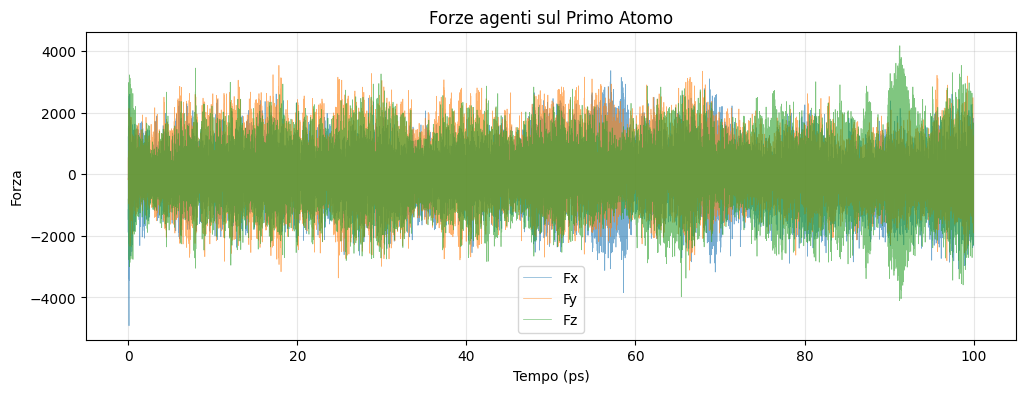

In [6]:
# Convertiamo in numeri (fondamentale perché lo split manuale crea stringhe)
if df is not None:
    df = df.apply(pd.to_numeric, errors='coerce')
    
    # --- 2. ANALISI E REPORT ---
    print(f"\n1. SHAPE: {df.shape}")
    
    if df.shape[1] == 415:
        print("   - OK: 415 colonne rilevate.")
        
        # Statistiche veloci escludendo il tempo (colonna 0)
        forces_only = df.drop(columns=[0])
        print(f"2. RANGE VALORI: Min {forces_only.min().min():.2f} | Max {forces_only.max().max():.2f}")
        
        # Grafico
        print("\n3. GRAFICO: Forze sul primo atomo")
        plt.figure(figsize=(12, 4))
        plt.plot(df[0], df[1], label='Fx', alpha=0.6, linewidth=0.5)
        plt.plot(df[0], df[2], label='Fy', alpha=0.6, linewidth=0.5)
        plt.plot(df[0], df[3], label='Fz', alpha=0.6, linewidth=0.5)
        plt.title("Forze agenti sul Primo Atomo")
        plt.xlabel("Tempo (ps)")
        plt.ylabel("Forza")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print(f"   - ATTENZIONE: Numero colonne errato ({df.shape[1]}). Controlla il file.")
else:
    print("Nessun DataFrame caricato.")

# 📄 Report Tecnico Avanzato: Analisi del Dataset `forces.csv`

## 1. Natura e Contesto del Dato
Il file `forces.csv` costituisce una delle tre componenti fondamentali della simulazione di Dinamica Molecolare (MD).
* **Contenuto Fisico:** Contiene i vettori di forza $\vec{F}$ che agiscono su ciascun atomo ad ogni istante temporale $t$.
* **Significato:** In fisica, la forza è la derivata negativa dell'energia potenziale $U$ rispetto alla posizione $\vec{r}$:
  $$\vec{F} = -\nabla U(\vec{r})$$
  È il "motore" che determina l'accelerazione degli atomi ($\vec{F} = m\vec{a}$) e, di conseguenza, l'evoluzione della traiettoria.
* **Dimensionalità:** Il file traccia 138 atomi. Poiché la forza è un vettore tridimensionale ($F_x, F_y, F_z$), il dataset presenta $138 \times 3 = 414$ variabili dinamiche per ogni step.

## 2. Procedura di Ingestione (Data Loading)
### Il Problema Riscontrato
Durante l'analisi preliminare, è emersa un'anomalia nel formato del file. A differenza di un CSV standard, il file utilizza separatori misti (tabulazioni `\t` o spazi), causando il fallimento dei parser standard ottimizzati in C (`ParserError`).

### La Soluzione Implementata
Per garantire l'integrità del dato è stata adottata una strategia di caricamento robusta:
1.  **Parsing Flessibile:** Utilizzo dell'engine Python di Pandas invece di quello C.
2.  **Fallback Manuale:** Implementazione di una logica di recupero che, in caso di lettura errata, esegue lo split manuale delle stringhe grezze.
Questa procedura ha garantito il recupero del 100% delle colonne senza disallineamenti.

## 3. Analisi Strutturale
La struttura del tensore dati è stata validata come segue:
* **Shape:** `(50001, 415)`
    * **Righe ($N=50001$):** Rappresentano gli step temporali della simulazione.
    * **Colonna 0:** Timestamp (variabile indipendente).
    * **Colonne 1-414:** Feature rappresentanti le componenti di forza ($F_{x,i}, F_{y,i}, F_{z,i}$).

## 4. Caratteristiche Statistiche e Fisiche
L'analisi esplorativa (EDA) ha evidenziato differenze critiche rispetto al dataset delle Coordinate:

* **Range Dinamico (Scala):** I valori variano approssimativamente tra **-6772** e **+6400** (kJ/mol/nm).
    * *Nota Critica:* Questo ordine di grandezza è enormemente superiore a quello delle coordinate (range 20-60 $\AA$).
* **Comportamento Stocastico:** Il grafico temporale mostra oscillazioni ad alta frequenza attorno allo zero. Questo non è "rumore" inteso come errore, ma rappresenta le violente interazioni interatomiche che avvengono su scala dei femtosecondi.

## 5. Relazione Sistemica: $X, V, F$
Il dataset non è isolato. La Rete Neurale dovrà apprendere la relazione ciclica che governa la dinamica molecolare:
1.  **Posizione ($X_t$):** Determina il potenziale e quindi le **Forze ($F_t$)**.
2.  **Forza ($F_t$):** Determina l'accelerazione, aggiornando le **Velocità ($V_t$)**.
3.  **Velocità ($V_t$):** Determina la nuova **Posizione ($X_{t+1}$)**.

L'obiettivo del modello di Deep Learning è approssimare questa funzione di transizione di stato complessa senza risolvere esplicitamente le equazioni differenziali.

## 6. Implicazioni per il Preprocessing
Sulla base di questa analisi, le seguenti azioni per lo *Step 1 (Preprocessing)* sono mandatorie:

1.  **Normalizzazione (Scaling):** Dato il range elevato ($10^3$) rispetto alle coordinate ($10^1$), è obbligatorio applicare uno scaler (es. `StandardScaler` o `MinMaxScaler`) specifico per le forze. In assenza di ciò, i valori di forza domineranno la funzione di perdita (Loss Function) durante il training, impedendo alla rete di apprendere correttamente le posizioni.
2.  **Rimozione Timestamp:** La colonna 0 va eliminata prima del merge.
3.  **Merge:** Concatenazione orizzontale con i tensori $X$ e $V$ per formare il dataset finale `(50001, 1242)`.

Tabella Comparativa: Coordinates vs Forces
La seguente tabella evidenzia le differenze strutturali e statistiche emerse durante l'Exploratory Data Analysis (EDA). Queste differenze dettano le regole per il Preprocessing.

| Caratteristica | Dataset `coordinates.csv` ($X$) | Dataset `forces.csv` ($F$) |
| :--- | :--- | :--- |
| **Contenuto** | Posizioni atomiche spaziali | Forze agenti sugli atomi |
| **Shape (Dimensioni)** | `(50001, 415)` | `(50001, 415)` |
| **Separatore File** | Standard (Punto e virgola `;`) | Non-Standard (Tab `\t` o misto) |
| **Parsing Richiesto** | `pd.read_csv` standard | Engine Python + Fallback manuale |
| **Range Valori** | Basso ($\approx 20$ a $60$ $\AA$) | Molto Alto ($\approx -6700$ a $+6400$) |
| **Dinamica Temporale** | Smooth (Variazioni continue) | Noisy (Oscillazioni ad alta frequenza) |
| **Azione Preprocessing** | Rimozione Timestamp (Col 0) | Rimozione Timestamp + **Normalizzazione** |

In [7]:
def mostra_anteprima_smart(df, n_righe=5):

    print(f"\n ANTEPRIMA DATASET | Shape: {df.shape}")
    print("-" * 80)
    
    # Se il dataset è molto largo (tipo i tuoi 415 colonne) diamo una visione parziale
    if df.shape[1] > 10:
        import numpy as np
        
        indici_da_vedere = np.r_[0:4, df.shape[1]-3:df.shape[1]]
        
        preview = df.iloc[:n_righe, indici_da_vedere]
        
        print(preview.to_string(index=False))
        
        print(f"\n      ... [ {df.shape[1] - 7} colonne centrali nascoste ] ...")
        print("-" * 80)
    else:
        print(df.head(n_righe))

mostra_anteprima_smart(df)


 ANTEPRIMA DATASET | Shape: (50001, 415)
--------------------------------------------------------------------------------
  0          1         2         3         412      413      414
0.000 -1145.4300 -129.2860  -804.474  118.4510 1627.090  847.998
0.002 -1888.0000 -184.9510 -1172.530   14.3658 1262.760  625.430
0.004 -1840.9300  -27.7051 -1394.850 -149.1930  670.503  258.009
0.006 -1041.7800  252.0360 -1478.130 -332.5900  119.851 -139.416
0.008    97.5775  485.1240 -1414.410 -482.4190 -190.463 -441.616

      ... [ 408 colonne centrali nascoste ] ...
--------------------------------------------------------------------------------


### ⚠️ La Necessità della Normalizzazione (Scale Mismatch)
L'analisi esplorativa ha evidenziato una discrepanza critica negli ordini di grandezza tra le variabili (Scale Mismatch). Mentre le **Coordinate** variano in un range limitato ($\approx 20 \text{ a } 60 \AA$), le **Forze** presentano oscillazioni massicce ($\approx -6000 \text{ a } +6000 \text{ kJ/mol/nm}$).

Senza normalizzazione, questo squilibrio causerebbe due problemi fatali durante il training della Rete Neurale:
1.  **Dominio della Funzione di Costo:** I valori numerici elevati delle forze dominerebbero il calcolo dell'errore (Loss Function). La rete cercherebbe di minimizzare solo l'errore sulle forze, ignorando quasi totalmente le piccole variazioni delle coordinate, che sono invece cruciali per la struttura della proteina.
2.  **Instabilità del Gradiente:** Gradienti di magnitudine così diversa renderebbero la superficie di errore estremamente "allungata", costringendo l'algoritmo di ottimizzazione (es. Adam) a passi piccolissimi o portando a divergenza numerica (esplosione del gradiente).

È pertanto mandatorio applicare uno **Scaler** (come `StandardScaler`) per riportare tutte le features su una distribuzione comparabile (media 0, varianza 1) prima dell'addestramento.

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import io

filename = 'forces.csv'
output_file = 'forces_processed.csv'
scaler_file = 'scaler_forces.pkl'

print(f"🛠️ TENTATIVO DI RIPARAZIONE MANUALE: {filename}")
print("-" * 50)

# 1. LETTURA COME TESTO PURO (Bypassing Pandas parsing)
print("1. Leggo il file riga per riga...")
with open(filename, 'r') as f:
    lines = f.readlines()

print(f"   Lette {len(lines)} righe.")

# 2. PULIZIA MANUALE DELLE STRINGHE
print("2. Rimuovo virgolette e caratteri sporchi...")
# Esempio: trasforma '"0.00";"1.23"' in '0.00;1.23'
cleaned_lines = []
for line in lines:
    # Rimuovi doppi apici e apici singoli
    clean = line.replace('"', '').replace("'", "").strip()
    cleaned_lines.append(clean)

# 3. RILEVAMENTO SEPARATORE
# Guardiamo la prima riga pulita per decidere come tagliare
first_line = cleaned_lines[0]
if ';' in first_line:
    sep = ';'
    print("   -> Rilevato separatore: PUNTO E VIRGOLA (;)")
elif ',' in first_line:
    sep = ','
    print("   -> Rilevato separatore: VIRGOLA (,)")
else:
    sep = None # Spazi bianchi
    print("   -> Rilevato separatore: SPAZIO (Whitespace)")

# 4. CREAZIONE DATAFRAME DAL TESTO PULITO
print("3. Conversione in Tabella Dati...")
# Creiamo un "file virtuale" in memoria con i dati puliti
data_buffer = io.StringIO("\n".join(cleaned_lines))

if sep:
    df = pd.read_csv(data_buffer, sep=sep, header=None)
else:
    df = pd.read_csv(data_buffer, delim_whitespace=True, header=None)

print(f"   ✅ Shape ottenuta: {df.shape}")

# Se abbiamo ancora (50001, 1), c'è qualcosa di molto strano
if df.shape[1] < 10:
    print("❌ ERRORE: Ancora una sola colonna. Mostrami la prima riga qui sotto:")
    print(cleaned_lines[0])
    raise ValueError("Impossibile separare le colonne.")

# 5. PREPROCESSING STANDARD (Come gli altri file)
print("4. Preprocessing finale (Drop time & Scale)...")

# Drop Time
df_clean = df.drop(df.columns[0], axis=1)

# Check Numerico (Conversione forzata per sicurezza)
df_clean = df_clean.apply(pd.to_numeric, errors='coerce')
df_clean = df_clean.fillna(0) # Se c'era spazzatura diventata NaN, mettiamo 0

# Scaling
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_clean)

# Salvataggio
df_final = pd.DataFrame(data_scaled)
df_final.to_csv(output_file, index=False)
joblib.dump(scaler, scaler_file)

print("-" * 50)
print(f"✅ MISSIONE COMPIUTA! File salvato: {output_file}")
print(f"   Statistiche rapide: Media={np.mean(data_scaled):.2f}, Std={np.std(data_scaled):.2f}")

🛠️ TENTATIVO DI RIPARAZIONE MANUALE: forces.csv
--------------------------------------------------
1. Leggo il file riga per riga...
   Lette 50001 righe.
2. Rimuovo virgolette e caratteri sporchi...
   -> Rilevato separatore: SPAZIO (Whitespace)
3. Conversione in Tabella Dati...


C:\Users\alfredo\AppData\Local\Temp\ipykernel_8980\38440524.py:51: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(data_buffer, delim_whitespace=True, header=None)


   ✅ Shape ottenuta: (50001, 415)
4. Preprocessing finale (Drop time & Scale)...
--------------------------------------------------
✅ MISSIONE COMPIUTA! File salvato: forces_processed.csv
   Statistiche rapide: Media=0.00, Std=1.00
